In [1]:
import numpy as np
import math
import heapq
import matplotlib.pyplot as plt
import scipy
from scipy import signal

all_points-- list точек

points--list точек в функциях

index, ind-- рассматриваемой точки

next_reach_d-- reachability_dist, наименьший по отношению всех точек к рассматриваемой в данный момент точке

In [2]:
UNDEFIEND = -1
NOT_VISITED = -1

class opt_struct:
    core_dist = UNDEFIEND
    coords = []
    index = 0
    def __lt__(self, other):
        if (self.index < other.index):
            return True
        else:
            return False
    
def get_core(points, ind, len_points, n_dist, min_pts):
    if (len(n_dist[ind]) >= min_pts):
        tmp = n_dist[ind]
        tmp.sort()
        return tmp[min_pts - 1]
    return UNDEFIEND
    
def make_opt_struct_list(points, len_points, n_dist, min_pts):
    opt_list = []
    for i in range(len_points):
        tmp = opt_struct()
        tmp.coords = points[i]
        tmp.core_dist = get_core(points, i, len_points, n_dist, min_pts)
        tmp.index = i
        opt_list.append(tmp)
    return opt_list

def dist(p1, p2):
    #euclidean dist
    #p1, p2--точки all_points
    len_c = len(p1)
    distance = 0
    for i in range(len_c):
        distance += (p1[i] - p2[i]) * (p1[i] - p2[i])
    return math.sqrt(distance)

def get_neighbors(points, now_ind, eps, length):
    neigh = []
    n_dist = []
    for j in range(length):
        d = dist(points[now_ind], points[j])
        if ( d <= eps):
            tmp = opt_struct()
            tmp.coords = points[j]
            tmp.index = j
            neigh.append(tmp)
            n_dist.append(d)
    return neigh, n_dist

In [3]:
def update(neigh, ind, seeds, eps, min_pts, opt_points, visited, length, reach_dist):
    coredist = opt_points[ind].core_dist
    for p in neigh:
        if (visited[p.index] == NOT_VISITED):
            new_reach_dist = max(coredist, dist(p.coords, opt_points[ind].coords))
            if ((reach_dist[p.index] == UNDEFIEND) or (new_reach_dist < reach_dist[p.index])):
                reach_dist[p.index] = new_reach_dist
                heapq.heappush(seeds, (new_reach_dist, p))
    return seeds

In [15]:
def extract_labels(queue, reach_dist, min_pts):
    result_dist = []
    for p in queue:
        result_dist.append(reach_dist[p.index])
    peaks, properties = scipy.signal.find_peaks(result_dist, distance = min_pts)
    peaks = np.append(peaks, len(result_dist))
    
    labels = [0 for i in range(len(result_dist))]
    prev_label = 0
    num_label = 1
    for cur_label in peaks:
        for point in range(prev_label, cur_label):
            if ((result_dist[point] != UNDEFIEND)
                and (labels[queue[point].index] == 0)):
                labels[queue[point].index] = num_label
        if ((cur_label < len(result_dist)) 
            and (result_dist[cur_label] != UNDEFIEND) 
            and (labels[queue[cur_label].index] == 0)):
                labels[queue[cur_label].index] = num_label
        prev_label = cur_label
        num_label += 1
    return labels

In [8]:
def OPTICS(all_points, eps, min_pts):

    length = len(all_points)
    
    all_neigh = []
    neigh_dists = []
    for i in range(length):
        neig, n_dist = get_neighbors(all_points, i, eps, length)
        all_neigh.append(neig)
        neigh_dists.append(n_dist)
    opt_points = make_opt_struct_list(all_points, length, neigh_dists, min_pts)
    for n in all_neigh: # n ~ neighbors
        for p in n: # p ~ point
            p.core_dist = opt_points[p.index].core_dist
    
    reach_dist = [UNDEFIEND for i in range(length)]
    visited = [NOT_VISITED for i in range(length)]
    queue = []
    
    for p in opt_points:
        if (visited[p.index] != NOT_VISITED):
            continue
        neigh = all_neigh[p.index]
        visited[p.index] = 1
        queue.append(p)
        reach_dist[p.index] = p.core_dist
        if (p.core_dist != UNDEFIEND):
            seeds = []
            seeds = update(neigh, p.index, seeds, eps, min_pts, opt_points, visited, length, reach_dist)
            while (len(seeds) != 0):
                q = heapq.heappop(seeds)
                if (visited[q[1].index] != NOT_VISITED):
                    continue
                visited[q[1].index] = 1
                queue.append(q[1])
                neigh = all_neigh[q[1].index]
                if (q[1].core_dist != UNDEFIEND):
                    seeds = update(neigh, q[1].index, seeds, eps, min_pts, opt_points, visited, length, reach_dist)
                    
    labels = extract_labels(queue, reach_dist, min_pts)
#     uncomment for graph
    x = []
    y = []
    for i in all_points:
        x.append(i[0])
        y.append(i[1])
    
    plt.scatter(x, y, c = labels, s = 1)
    
    return labels

$\textbf{Example}$

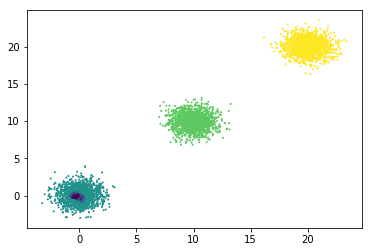

In [17]:
from numpy import random
N = 3000
n = N // 2
np.random.seed(42)
x = np.random.normal(0, 1, (n, 2))
x = np.append(x, np.random.normal(10, 1, (n, 2)), axis=0)
x = np.append(x, np.random.normal(20, 1, (n, 2)), axis=0)
# plt.plot(x)
min_pts = 100
eps = 5
labels = OPTICS(x, eps, min_pts)
# print(labels)